In [3]:
!Cabocha -f1 data/neko.txt > work/neko.txt.cabocha

^C


In [7]:
!wget https://nlp100.github.io/data/ai.ja.zip -P data/

--2020-07-09 11:07:04--  https://nlp100.github.io/data/ai.ja.zip
nlp100.github.io (nlp100.github.io) をDNSに問いあわせています... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
nlp100.github.io (nlp100.github.io)|185.199.108.153|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 17516 (17K) [application/zip]
`data/ai.ja.zip.1' に保存中

ai.ja.zip.1         100%[===================>]  17.11K  --.-KB/s 時間 0.1s       

2020-07-09 11:07:05 (118 KB/s) - `data/ai.ja.zip.1' へ保存完了 [17516/17516]



In [14]:
!unzip data/ai.ja.zip -d data/

Archive:  data/ai.ja.zip
  inflating: data/ai.ja.txt          
  inflating: data/readme.ai.ja.md    


In [ ]:
!pip install ginza

In [ ]:
!pip install spacy

In [54]:
!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.3.1) ======================
ℹ spaCy installation:
/Users/y_nakamura/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/spacy

No models found in your current environment.



In [59]:
import spacy
nlp = spacy.load('ja_ginza')

with open('./data/ai.ja.txt') as in_file:
    with open('./data/prepro_ai.ja.txt', mode='w') as out_file:
        for line in in_file:
            doc = nlp(line.strip())
            for sent in doc.sents:
                out_file.write(str(sent) + '\n')

In [60]:
!Cabocha -f1 data/prepro_ai.ja.txt > work/ai.ja.txt.cabocha

# 40. 係り受け解析結果の読み込み（形態素）

In [1]:
class Morph:
    def __init__(self, parse_result):
        morph = self._txt2morph(parse_result)
        self.surface = morph['surface']
        self.base = morph['base'] 
        self.pos = morph['pos'] 
        self.pos1 = morph['pos1']

    def _txt2morph(self, parse_result):
        splited_parse_result = parse_result.split('\t')
        splited_parse_result[1] = splited_parse_result[1].split(',')
        return {
            'surface':splited_parse_result[0],
            'base':splited_parse_result[1][6],
            'pos':splited_parse_result[1][0],
            'pos1':splited_parse_result[1][1]
        }
    
    def get_members_string(self):
        return f'surface : {self.surface}\tbase : {self.base}\tpos : {self.pos}\tpos1 : {self.pos1}'

In [2]:
def make_morph_sentence():
    with open('./work/ai.ja.txt.cabocha', mode = 'r') as f:
        sentence = list() 
        for line in f:
            line = line.rstrip()
            if line == 'EOS':
                if sentence: yield sentence
                sentence = list()
                continue
            if line[0] == '*' and line[1] == ' ': continue
            sentence.append(Morph(line))

In [3]:
from itertools import islice

In [4]:
gen_morph_sentence = make_morph_sentence()
for sentence in islice(gen_morph_sentence, 1, 2):
    for morph in sentence:
        print(morph.get_members_string())
    print()

surface : 人工	base : 人工	pos : 名詞	pos1 : 一般
surface : 知能	base : 知能	pos : 名詞	pos1 : 一般
surface : （	base : （	pos : 記号	pos1 : 括弧開
surface : じん	base : じん	pos : 名詞	pos1 : 一般
surface : こうち	base : こうち	pos : 名詞	pos1 : 一般
surface : のう	base : のう	pos : 助詞	pos1 : 終助詞
surface : 、	base : 、	pos : 記号	pos1 : 読点
surface : 、	base : 、	pos : 記号	pos1 : 読点
surface : AI	base : *	pos : 名詞	pos1 : 一般
surface : 〈	base : 〈	pos : 記号	pos1 : 括弧開
surface : エーアイ	base : *	pos : 名詞	pos1 : 固有名詞
surface : 〉	base : 〉	pos : 記号	pos1 : 括弧閉
surface : ）	base : ）	pos : 記号	pos1 : 括弧閉
surface : と	base : と	pos : 助詞	pos1 : 格助詞
surface : は	base : は	pos : 助詞	pos1 : 係助詞
surface : 、	base : 、	pos : 記号	pos1 : 読点
surface : 「	base : 「	pos : 記号	pos1 : 括弧開
surface : 『	base : 『	pos : 記号	pos1 : 括弧開
surface : 計算	base : 計算	pos : 名詞	pos1 : サ変接続
surface : （	base : （	pos : 記号	pos1 : 括弧開
surface : ）	base : ）	pos : 記号	pos1 : 括弧閉
surface : 』	base : 』	pos : 記号	pos1 : 括弧閉
surface : という	base : という	pos : 助詞	pos1 : 格助詞
surface : 概念	base : 概念	pos : 名詞	pos1 : 一般

# 41. 係り受け解析結果の読み込み（文節・係り受け）

In [5]:
from operator import itemgetter
from functools import reduce

In [6]:
'''
Class Chunk
文節のクラス
---Member---
morphs: 形態素のリスト 
dst: 係り先文節インデックス番号
srcs: 係り元文節インデックス番号のリスト
'''
class Chunk(Morph):
    def __init__(self):
        self.morphs = list()
        self.dst = -1
        self.srcs = list()
    
    def append_morph(self, parse_result):
        self.morphs.append(Morph(parse_result))
        
    def append_srcs(self, src):
        self.srcs.append(src)
    
    def set_dst(self, dst):
        self.dst = dst
    
    def get_members_string(self):
        morphs = reduce(lambda a, b: a + '(' + b.get_members_string() + ')\n', self.morphs, '')
        return f'morphs : \n{morphs}dst : {self.dst}\tsrcs : {self.srcs}'

    def morphs2strip_string(self):
        return reduce(lambda a, b: a + (b.surface if b.pos != '記号' else ''), self.morphs, '')
    
    def morphs2string(self):
        return reduce(lambda a, b: a + b.surface, self.morphs, '')
    
    def check_pos(self, pos):
        for morph in self.morphs:
            if morph.pos == pos: return True
        return False

In [7]:
def make_chunk_sentence():
    with open('./work/ai.ja.txt.cabocha', mode = 'r') as f:
        chunk_dict = dict()
        for line in f:
            line = line.rstrip()
            if line == 'EOS':
                sentence = [x[1] for x in sorted(chunk_dict.items(), key = itemgetter(0))]
                if sentence: yield sentence
                chunk_dict = dict()
                continue
            if line[0] == '*' and line[1] == ' ':
                splited_line = line.split()
                idx = int(splited_line[1])
                dst = int(splited_line[2][:-1])
                if not idx in chunk_dict: chunk_dict[idx] = Chunk()
                chunk_dict[idx].set_dst(dst)
                if dst != -1 and not dst in chunk_dict: chunk_dict[dst] = Chunk()
                if dst != -1: chunk_dict[dst].append_srcs(idx)
            else:
                chunk_dict[idx].append_morph(line)

In [8]:
gen_chunk_sentence = make_chunk_sentence()
for sentence in islice(gen_chunk_sentence, 1, 2):
    for chunk in sentence:
        print(chunk.get_members_string())
    print()

morphs : 
(surface : 人工	base : 人工	pos : 名詞	pos1 : 一般)
(surface : 知能	base : 知能	pos : 名詞	pos1 : 一般)
dst : 17	srcs : []
morphs : 
(surface : （	base : （	pos : 記号	pos1 : 括弧開)
(surface : じん	base : じん	pos : 名詞	pos1 : 一般)
(surface : こうち	base : こうち	pos : 名詞	pos1 : 一般)
(surface : のう	base : のう	pos : 助詞	pos1 : 終助詞)
(surface : 、	base : 、	pos : 記号	pos1 : 読点)
(surface : 、	base : 、	pos : 記号	pos1 : 読点)
dst : 17	srcs : []
morphs : 
(surface : AI	base : *	pos : 名詞	pos1 : 一般)
dst : 3	srcs : []
morphs : 
(surface : 〈	base : 〈	pos : 記号	pos1 : 括弧開)
(surface : エーアイ	base : *	pos : 名詞	pos1 : 固有名詞)
(surface : 〉	base : 〉	pos : 記号	pos1 : 括弧閉)
(surface : ）	base : ）	pos : 記号	pos1 : 括弧閉)
(surface : と	base : と	pos : 助詞	pos1 : 格助詞)
(surface : は	base : は	pos : 助詞	pos1 : 係助詞)
(surface : 、	base : 、	pos : 記号	pos1 : 読点)
dst : 17	srcs : [2]
morphs : 
(surface : 「	base : 「	pos : 記号	pos1 : 括弧開)
(surface : 『	base : 『	pos : 記号	pos1 : 括弧開)
(surface : 計算	base : 計算	pos : 名詞	pos1 : サ変接続)
dst : 5	srcs : []
morphs : 
(surface : （	base

# 42. 係り元と係り先の文節の表示

In [9]:
gen_sentence = make_chunk_sentence()
for sentence in islice(gen_sentence, 1, 2):
    for chunk in sentence:
        if chunk.dst != -1: print(f'{chunk.morphs2strip_string()}\t{sentence[chunk.dst].morphs2strip_string()}')
    print()

人工知能	語
じんこうちのう	語
AI	エーアイとは
エーアイとは	語
計算	という
という	道具を
概念と	道具を
コンピュータ	という
という	道具を
道具を	用いて
用いて	研究する
知能を	研究する
研究する	計算機科学
計算機科学	の
の	一分野を
一分野を	指す
指す	語



# 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

In [10]:
noun_to_verb = list()
for sentence in make_chunk_sentence():
    for chunk in sentence:
        if chunk.dst == -1: continue
        if chunk.check_pos('名詞') and sentence[chunk.dst].check_pos('動詞'):
            noun_to_verb.append((chunk.morphs2strip_string(), sentence[chunk.dst].morphs2strip_string()))

In [11]:
for idx in range(10):
    print('\t'.join(noun_to_verb[idx]))

道具を	用いて
知能を	研究する
一分野を	指す
知的行動を	代わって
人間に	代わって
コンピューターに	行わせる
研究分野とも	される
解説で	述べている
佐藤理史は	述べている
次のように	述べている


# 44. 係り受け木の可視化

In [12]:
import pydot
from IPython.display import Image, display

In [13]:
graph = pydot.Dot(graph_type = 'digraph')
for sentence in islice(make_chunk_sentence(), 1, 2):
    for idx, chunk in enumerate(sentence):
        if chunk.dst == -1: continue
        id1 = idx
        id2 = chunk.dst
        label1 = chunk.morphs2strip_string()
        label2 = sentence[id2].morphs2strip_string()
        graph.add_node(pydot.Node(id1, label=label1))
        graph.add_node(pydot.Node(id2, label=label2))
        graph.add_edge(pydot.Edge(id1, id2))

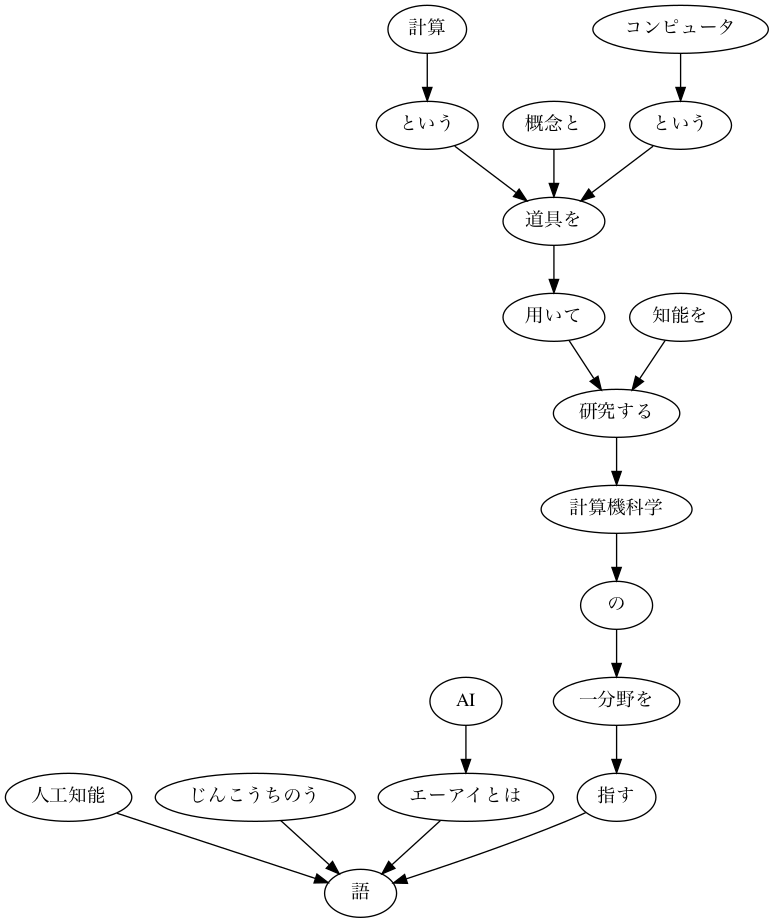

In [14]:
plt = Image(graph.create_png())
display(plt)

# 45. 動詞の格パターンの抽出

In [15]:
with open('./work/case_info.txt', mode = 'w') as out_file:
    for sentence in make_chunk_sentence():
        for chunk in sentence:
            verb = ''
            for morph in chunk.morphs:
                if morph.pos == '動詞':
                    verb = morph.base
                    break
            if verb:
                particle_list = list()
                for src in chunk.srcs:
                    src_chunk = sentence[src]
                    
                    #TODO:動詞に係る助詞を全て抽出に変更する
                    if src_chunk.morphs[-1].pos == '記号' and len(src_chunk.morphs) > 1: morph = src_chunk.morphs[-2]
                    else: morph = src_chunk.morphs[-1]
                        
                    if morph.pos == '助詞':
                        particle_list.append(morph.base)
                if particle_list:
                    out_file.write(verb + '\t' + ' '.join(sorted(particle_list)) + '\n')

一文節内に複数の助詞がある場合どうすんnen(文節の最後に助詞が来ているもののみを抽出)

In [16]:
!cat ./work/case_info.txt | sort | uniq -c | sort -r | head -n 10 

     54 する	を
     19 する	と
     18 する	が
     16 する	に
     12 する	は を
     11 よる	に
     10 する	に を
      9 する	と は
      9 する	で を
      8 行う	を


In [17]:
!grep -E "^行う|^なる|^与える" ./work/case_info.txt | sort | uniq -c | sort -r 

      8 行う	を
      4 なる	に は
      3 なる	が と
      2 行う	は を
      2 与える	が に
      2 なる	は も
      2 なる	に
      2 なる	と
      1 行う	は を をめぐって
      1 行う	は は は
      1 行う	に を を
      1 行う	に まで を
      1 行う	に により を
      1 行う	に
      1 行う	で を
      1 行う	で は まで を
      1 行う	で に を
      1 行う	て に を
      1 行う	て に
      1 行う	が は
      1 行う	が に は
      1 行う	が で は
      1 行う	から
      1 与える	に は を
      1 なる	は は
      1 なる	として に は
      1 なる	と など は
      1 なる	で は
      1 なる	で に は
      1 なる	が にとって は
      1 なる	が に は
      1 なる	が に
      1 なる	が で と に は は
      1 なる	が が と
      1 なる	から で と
      1 なる	から が て と は ば


In [18]:
!awk '{if(match($1, "^行う|^なる|^与える")){print $0}}' ./work/case_info.txt | sort | uniq -c | sort -r 

      8 行う	を
      4 なる	に は
      3 なる	が と
      2 行う	は を
      2 与える	が に
      2 なる	は も
      2 なる	に
      2 なる	と
      1 行う	は を をめぐって
      1 行う	は は は
      1 行う	に を を
      1 行う	に まで を
      1 行う	に により を
      1 行う	に
      1 行う	で を
      1 行う	で は まで を
      1 行う	で に を
      1 行う	て に を
      1 行う	て に
      1 行う	が は
      1 行う	が に は
      1 行う	が で は
      1 行う	から
      1 与える	に は を
      1 なる	は は
      1 なる	として に は
      1 なる	と など は
      1 なる	で は
      1 なる	で に は
      1 なる	が にとって は
      1 なる	が に は
      1 なる	が に
      1 なる	が で と に は は
      1 なる	が が と
      1 なる	から で と
      1 なる	から が て と は ば


# 46. 動詞の格フレーム情報の抽出

In [19]:
with open('./work/case_frame_info.txt', mode='w') as out_file:
    for sentence in make_chunk_sentence():
        for chunk in sentence:
            verb = ''
            for morph in chunk.morphs:
                if morph.pos == '動詞':
                    verb = morph.base
                    break
            if verb:
                particle_clause_list = list()
                for src in chunk.srcs:
                    src_chunk = sentence[src]
                    
                    #記号を除いた後の末尾が助詞の場合
                    morph = None 
                    for src_morph in src_chunk.morphs[::-1]:
                        if src_morph.pos == '記号':
                            continue
                        else:
                            if src_morph.pos == '助詞':
                                morph = src_morph
                            else:
                                break
                        
                    if morph and morph.pos == '助詞':
                        particle_clause_list.append((morph.base, sentence[src].morphs2string()))
                        
                sorted_particle_clause_list = sorted(particle_clause_list)
                particle_list = [x[0] for x in sorted_particle_clause_list]
                clause_list = [x[1] for x in sorted_particle_clause_list] 
                out_file.write(verb + '\t' + ' '.join(particle_list) + '\t' + ' '.join(clause_list) + '\n')

In [20]:
!cat work/case_frame_info.txt | head

用いる	を	道具を
する	て を	用いて 『知能』を
指す	を	一分野」を
代わる	に を	人間に 知的行動を
行う	て に	代わって コンピューターに
する	と	研究分野」とも
述べる	で に は	解説で、 次のように 佐藤理史は
する	で を	コンピュータ上で 知的能力を
する	を	推論・判断を
する	を	画像データを


助詞でソート

# 47. 機能動詞構文のマイニング

In [21]:
with open('./work/case_frame_util_info.txt', mode='w') as out_file:
    for sentence in make_chunk_sentence():
        for idx, chunk in enumerate(sentence):
            
            #ここ直すかも
            if len(chunk.morphs) == 2:
                morphs = chunk.morphs 
                if morphs[0].pos == '名詞' and morphs[0].pos1 == 'サ変接続' and morphs[1].surface == 'を' and morphs[1].pos == '助詞':
                    if chunk.dst != -1 and sentence[chunk.dst].check_pos('動詞'): #係り先に動詞が含まれる
                        verb = ''
                        for morph in sentence[chunk.dst].morphs: #最左の動詞
                            if morph.pos == '動詞':
                                verb = morph.base
                                break
            
            
                        particle_clause_list = list()
                        for src in sentence[chunk.dst].srcs:
                            if src == idx: continue
                            src_chunk = sentence[src]
                            
                            #記号を除いた後の末尾が助詞の場合
                            morph = None 
                            for src_morph in src_chunk.morphs[::-1]:
                                if src_morph.pos == '記号':
                                    continue
                                else:
                                    if src_morph.pos == '助詞':
                                        morph = src_morph
                                    else:
                                        break
                                
                            if morph and morph.pos == '助詞':
                                particle_clause_list.append((morph.base, sentence[src].morphs2string()))
                        sorted_particle_clause_list = sorted(particle_clause_list)
                        particle_list = [x[0] for x in sorted_particle_clause_list]
                        clause_list = [x[1] for x in sorted_particle_clause_list] 
                        out_file.write(chunk.morphs2string() + verb + '\t' + ' '.join(particle_list) + '\t' + ' '.join(clause_list) + '\n')

In [22]:
!cat ./work/case_frame_util_info.txt

記述をする	と	主体と
注目を集める	が	「サポートベクターマシン」が
経験を行う	に を	元に 学習を
学習を行う	に を	元に 経験を
流行を超える		
学習を繰り返す		
進化を見せる	て において は	加えて、 生成技術において （敵対的生成ネットワーク）は、
開発を行う	は	エイダ・ラブレスは
テストをする		
処理を行う		
意味をする	に	データに
研究を進める	て	費やして
命令をする	で	機構で
運転をする	に	元に
特許をする	が まで	日本が 2018年までに
研究をする		
運転をする	て に	基づいて、 柔軟に
注目を集める	から は	ことから、 ファジィは
成功を受ける		
制御をする	から	少なさから、
進歩を担う		
研究を続ける	が て	ジェフ・ホーキンスが、 向けて
注目を集める	に	急速に
普及を受ける		
投資を行う	で に	民間企業主導で 全世界的に
探索を行う	で	無報酬で
推論をする	て	経て
研究を行う	は	Googleは、
実験をする		
投資をする	は まで	韓国は、 2022年までに
反乱を起こす	て に対して	於いて、 人間に対して
弾圧を併せ持つ		
監視を行う	に まで	人工知能に 歩行者まで
差別を認める		
研究をする		
展開を変える		
戦争をする		
判断を介す	から	観点から
禁止を求める	が に	ヒューマン・ライツ・ウォッチが、 4月には
運用をめぐる		
記録をする		
試験を行う		
追及を受ける	で で と とともに	公聴会では、 整合性で 拒否すると 「」とともに、
解任をする	は	Google社員らは
解散をする	が で は	倫理委員会が 理由で、 Googleは
実現をする		
話をする	は ば	哲学者は よれば、
勘違いをする		
議論を行う	で は まで	対談で 須藤は 「これまで


In [23]:
!cat ./work/case_frame_util_info.txt | cut -f 1 | sort | uniq -c | sort -r | head -n 10 

      3 注目を集める
      2 運転をする
      2 研究をする
      1 開発を行う
      1 運用をめぐる
      1 進歩を担う
      1 進化を見せる
      1 追及を受ける
      1 議論を行う
      1 話をする


In [24]:
!cat ./work/case_frame_util_info.txt | cut -f1,2 | sort | uniq -c | sort -r | head -n 10 

      2 研究をする	
      1 開発を行う	は
      1 運転をする	に
      1 運転をする	て に
      1 運用をめぐる	
      1 進歩を担う	
      1 進化を見せる	て において は
      1 追及を受ける	で で と とともに
      1 議論を行う	で は まで
      1 話をする	は ば


# 48. 名詞から根へのパスの抽出

In [25]:
def rec(chunk, sentence, noun_path_idx):
    noun_path_idx.append(chunk.dst)
    if chunk.dst == -1: return
    rec(sentence[chunk.dst], sentence, noun_path_idx)

    
def noun_path_idx2noun_path(noun_path_idx, sentence):
    return [sentence[idx].morphs2string() for idx in noun_path_idx if idx != -1]

In [26]:
noun_path_list = list()
for sentence in islice(make_chunk_sentence(), 100):
    for idx, chunk in enumerate(sentence):
        if chunk.check_pos('名詞'):
            noun_path_idx = [idx]
            rec(chunk, sentence, noun_path_idx)
            noun_path_list.append(noun_path_idx2noun_path(noun_path_idx, sentence))

In [43]:
for idx in range(10):
    noun_path = noun_path_list[idx]
    print(' -> '.join(noun_path))

人工知能
人工知能 -> 語。
（じんこうちのう、、 -> 語。
AI -> 〈エーアイ〉）とは、 -> 語。
〈エーアイ〉）とは、 -> 語。
「『計算 -> （）』という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す -> 語。
概念と -> 道具を -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す -> 語。
『コンピュータ -> （）』という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す -> 語。
道具を -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す -> 語。
『知能』を -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す -> 語。


# 49. 名詞間の係り受けパスの抽出

In [40]:
def mask(chunk, mask_char):
    masked_string = ''
    noun_continue = False
    masked = False
    for morph in chunk.morphs:
        if morph.pos == '名詞':
            #名詞句はまとめてマスク
            if not masked:
                masked_string += mask_char
                masked = True
                noun_continue = True
            else:
                if noun_continue: continue
                else: masked_string += morph.surface
        else:
            noun_continue = False
            masked_string += morph.surface
    return masked_string

In [41]:
noun_to_noun_path_list = list()
for sentence in make_chunk_sentence():
    for x_idx, x_chunk in enumerate(sentence):
        if not x_chunk.check_pos('名詞'): continue
        for y_idx, y_chunk in enumerate(sentence[x_idx + 1:]):
            y_idx += x_idx + 1
            if not y_chunk.check_pos('名詞'): continue
            x_noun_path_idx = [x_idx]
            rec(x_chunk, sentence, x_noun_path_idx)
            y_noun_path_idx = [y_idx]
            rec(y_chunk, sentence, y_noun_path_idx)
            while x_noun_path_idx and y_noun_path_idx and x_noun_path_idx[-1] == y_noun_path_idx[-1]:
                x_noun = x_noun_path_idx.pop(-1)
                y_noun = y_noun_path_idx.pop(-1)
            if y_noun_path_idx:
                out_str = ''
                x_noun_path = noun_path_idx2noun_path(x_noun_path_idx, sentence)
                x_noun_path[0] = mask(x_chunk, 'X')
                out_str += ' -> '.join(x_noun_path) + ' | '
                y_noun_path = noun_path_idx2noun_path(y_noun_path_idx, sentence)
                y_noun_path[0] = mask(y_chunk, 'Y')
                out_str += ' -> '.join(y_noun_path) + ' | '
                out_str += sentence[x_noun].morphs2string()
                noun_to_noun_path_list.append(out_str)
            else:
                out_str = ''
                x_noun_path = noun_path_idx2noun_path(x_noun_path_idx, sentence)
                x_noun_path[0] = mask(x_chunk, 'X')
                x_noun_path.append(mask(y_chunk, 'Y'))
                out_str += ' -> '.join(x_noun_path)
                noun_to_noun_path_list.append(out_str)

In [42]:
for noun_to_noun_path in noun_to_noun_path_list[:30]:
    print(noun_to_noun_path)

X | （Yのう、、 | 語。
X | Y -> 〈エーアイ〉）とは、 | 語。
X | 〈Y〉）とは、 | 語。
X | 「『Y -> （）』という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
X | Yと -> 道具を -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
X | 『Y -> （）』という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
X | Yを -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
X | 『Y』を -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
X | Yする -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
X | Y -> （）の -> 一分野」を -> 指す | 語。
X | Y」を -> 指す | 語。
X -> Y。
（Xのう、、 | Y -> 〈エーアイ〉）とは、 | 語。
（Xのう、、 | 〈Y〉）とは、 | 語。
（Xのう、、 | 「『Y -> （）』という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
（Xのう、、 | Yと -> 道具を -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
（Xのう、、 | 『Y -> （）』という -> 道具を -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
（Xのう、、 | Yを -> 用いて -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
（Xのう、、 | 『Y』を -> 研究する -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
（Xのう、、 | Yする -> 計算機科学 -> （）の -> 一分野」を -> 指す | 語。
（Xのう、、 | Y -> （）の -> 一分野」を -> 指す | 語。
（Xのう、、 | Y」を -> 指す |

逆方向に係らないからi < jでおけ   